<a href="https://colab.research.google.com/github/lemonyun/keras_study/blob/main/6_3_advanced_usage_of_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.8.0'

순환 신경망의 성능과 일반화 능력을 향상시키기 위한 세 가지의 고급 기술을 살펴보겠습니다.

* 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
* 순환 층 스태킹 : 네트워크의 표현 능력을 증가시킵니다(대신 계산 비용이 많이 듭니다).
* 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

data_dir = './gdrive/MyDrive/datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [ ]:
from matplotlib import pyplot as plt

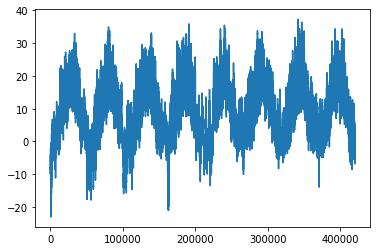

In [ ]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

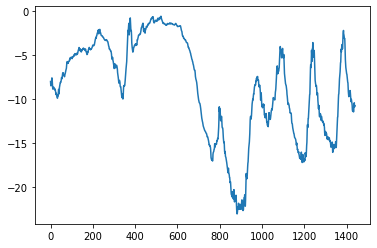

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 상식 수준의 기준점

이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다:

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [ ]:
0.29 * std[1]

2.5672247338393395

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

다음 코드는 데이터를 펼쳐서 두 개의 Dense 층을 통과시키는 완전 연결 네트워크를 보여줍니다. 전형적인 회귀 문제이므로 마지막 Dense 층에 활성화 함수를 두지 않았습니다. 손실 함수는 MAE입니다. 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해볼 수 있습니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 22s 42ms/step - loss: 1.8510 - val_loss: 1.1184
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.5945 - val_loss: 0.3817
Epoch 3/20
500/500 [==============================] - 17s 33ms/step - loss: 0.3121 - val_loss: 0.3164
Epoch 4/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2720 - val_loss: 0.3213
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2573 - val_loss: 0.3195
Epoch 6/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2482 - val_loss: 0.3176
Epoch 7/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2415 - val_loss: 0.3158
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2350 - val_loss: 0.3573
Epoch 9/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2311 - val_loss: 0.3095
Epoch 10/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2283 - val_los

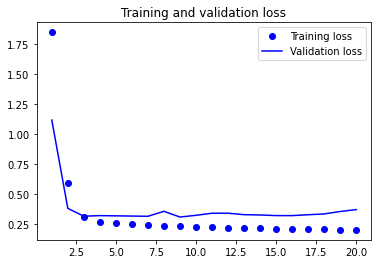

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

간단하고 괜찮은 성능을 내는 모델(상식 수준의 기준 모델)이 데이터와 타깃을 매핑할 수 있다면 왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까요? 훈련 과정이 찾는 것은 간단한 이 모델이 아니기 때문입니다. 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설 공간은 우리가 매개변수로 설정한 두 개 층을 가진 네트워크의 모든 가능한 가중치의 조합입니다. 이 네트워크는 이미 매우 복잡합니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있습니다. 심지어 기술적으로 봤을 때 이 가설 공간에 포함되어 있을 때 조차도 말이죠. 이것이 일반적으로 머신 러닝이 가진 심각한 제약 사항입니다. 학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있습니다.

# 첫 번째 순환 신경망

## GRU

이전 절에서 소개한 LSTM 층 대신에 2014년에 정준영 등이 개발한 GRU 층을 사용하겠습니다. GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 듭니다(LSTM 만큼 표현 학습 능력이 높지는 않을 수 있습니다). 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장합니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 89s 174ms/step - loss: 0.3034 - val_loss: 0.2720
Epoch 2/20
500/500 [==============================] - 84s 168ms/step - loss: 0.2857 - val_loss: 0.2651
Epoch 3/20
500/500 [==============================] - 87s 175ms/step - loss: 0.2795 - val_loss: 0.2661
Epoch 4/20
500/500 [==============================] - 84s 168ms/step - loss: 0.2738 - val_loss: 0.2632
Epoch 5/20
500/500 [==============================] - 84s 168ms/step - loss: 0.2695 - val_loss: 0.2607
Epoch 6/20
500/500 [==============================] - 81s 162ms/step - loss: 0.2649 - val_loss: 0.2640
Epoch 7/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2620 - val_loss: 0.2662
Epoch 8/20
500/500 [==============================] - 82s 165ms/step - loss: 0.2556 - val_loss: 0.2634
Epoch 9/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2547 - val_loss: 0.2682
Epoch 10/20
500/500 [==============================] - 82s 163ms/step - loss: 0.2492

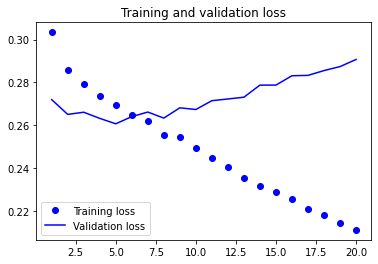

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선할 수 있을 것 같습니다

## 1. 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어지기 시작합니다. 이런 현상을 해결하기 위해 잘 알려진 드롭아웃 기법을 이미 보았습니다. **훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관 관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법입니다.** 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 2015년 야린 갈이 베이지안 딥러닝에 관한 박사 논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아 내었습니다. 

타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다.

케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있습니다. dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. recurrent_dropout은 순환 상태의 드롭아웃 비율을 정합니다. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠습니다. 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸립니다. 에포크를 두 배 더 늘려 네트워크를 훈련하겠습니다.

In [21]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 143s 282ms/step - loss: 0.3289 - val_loss: 0.2839
Epoch 2/40
500/500 [==============================] - 141s 282ms/step - loss: 0.3040 - val_loss: 0.2733
Epoch 3/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2980 - val_loss: 0.2801
Epoch 4/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2944 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 141s 283ms/step - loss: 0.2902 - val_loss: 0.2754
Epoch 6/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2867 - val_loss: 0.2732
Epoch 7/40
500/500 [==============================] - 141s 283ms/step - loss: 0.2823 - val_loss: 0.2659
Epoch 8/40
500/500 [==============================] - 141s 283ms/step - loss: 0.2785 - val_loss: 0.2741
Epoch 9/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2763 - val_loss: 0.2674
Epoch 10/40
500/500 [==============================] - 139s 278ms/step - lo

KeyboardInterrupt: ignored

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. 스태킹 순환 층 (순환층 쌓는다는 뜻)

과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다고 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 **층에 있는 유닛의 수를 늘리거나** **층을 더 많이 추가합니다.** 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법입니다. 예를 들어 구글 번역 알고리즘의 현재 성능은 7개의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것입니다.

케라스에서 순환 층을 차례대로 쌓으려면 **모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다.** return_sequences=True로 지정하면 됩니다:

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

## 3. 양방향 RNN 사용하기

양방향 RNN은 단반향 RNN이 놓치기 쉬운 패턴을 감지할 수 있다.


In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다. 

머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 많이 다를수록 더 좋습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 **앙상블**의 개념입니다.

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

이 네트워크는 일반 GRU 층과 비슷한 성능을 냅니다. 이유는 쉽게 이해할 수 있습니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문입니다(최근의 정보가 오래 전의 정보보다 훨씬 더 중요합니다).

# 더 나아가서
온도 예측 문제의 성능을 향상하기 위해 시도해 볼 수 있는 것들이 많이 있습니다.

* 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
* RMSprop 옵티마이저가 사용한 학습률을 조정합니다.
* GRU 대신 LSTM 층을 사용합니다.
* 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층이나 Dense 층을 스태킹합니다.
* 최종적으로 (검증 MAE 기준으로 봤을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.

늘 그렇듯이 딥러닝은 과학보다는 예술에 가깝습니다. 어떤 문제에 적합하거나 그렇지 않은 가이드라인은 제시할 수 있지만 결국 모든 문제는 다릅니다. 경험을 바탕으로 다른 전략들을 시도해 봐야 합니다. 현재는 문제를 해결하는 최선의 방법을 미리 알 수 있는 이론이 없습니다. 반복해서 시도해야 합니다.